In [1]:
import os
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, convolve1d
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, erosion
from skimage.color import label2rgb
import glob

## We will be using image processing techniques and the skimage package to determine whether or not an ionic liquid - solvent mixture is phase separated

## The first step will be to convolve the image.  This process smooths out some of the shadowing from the VMD-rendered image

In [3]:
def _convolveImage(image, kernel):
    def scaleIt(cvld):
        cvld[cvld > 255.0] = 255.0
        cvld[cvld < 0.0] = 0.0
        return cvld
    convolved = np.ones(image.shape)
    for i in range(convolved.shape[-1]):
        cvld = convolve2d(image[:,:,i], kernel, boundary='fill', mode='same',
                          fillvalue=0.)
        convolved[:,:,i] = scaleIt(cvld)

    #plt.imshow(convolved.astype(int))
    return convolved.astype(int)

## Next we will threshold a gray-scale image via Otsu's method

In [4]:
def _apply_otsu(gray):
    thresh_otsu = threshold_otsu(gray)
    im_bw = gray > thresh_otsu
    
    return im_bw

### In some image processing tutorial, the borders are cleared so that objects near the border aren't counted.  I am skipping this step so that in theory I can still count these objects.

### To clean up the image, I am going to play around with a cutoff to delete objects that may be either noise or a single atom, which we don't want to count towards total objects.  A filtered image as well as the image properties will be passed into `_cutoff_particles`

In [5]:
def _cutoff_particles(image, image_props, cutoff=300):
    im_bw_filt = image > 1
    
    # Loop through image properties and delete small objects
    n_regions = 0
    for prop in im_props:
        if prop.area < cutoff:
            im_bw_filt[image==prop.label] == False
        else:
            n_regions += 1
            
    #print('Number of individual regions = {}'.format(n_regions))
    
    return n_regions

### Now we will loop through our images and see how our image processing workflow performs

In [6]:
hetero_list = list()
sigma = 8
unsharp_strength = 0.8
kernel_size = 10
kernel = np.ones((kernel_size, kernel_size)) / kernel_size
kernel[0,:]
for filepath in glob.iglob('/Users/raymatsumoto/science/keras-phase-sep/data/train-images/hetero/*.png'):
    image = imread(filepath)
    blurred = gaussian_filter(image, sigma=0.8)
    convolved = _convolveImage(image - unsharp_strength * blurred, kernel)
    gray = convolved[:,:,0]
    im_bw = _apply_otsu(gray)
    im_labeled, n_labels = label(im_bw, background=0, return_num=True)
    im_labeled += 1
    
    im_props = regionprops(im_labeled)
    n_regions = _cutoff_particles(im_labeled, im_props, cutoff=300)
    hetero_list.append(n_regions)

In [7]:
homo_list = list()
sigma = 8
unsharp_strength = 0.8
kernel_size = 10
kernel = np.ones((kernel_size, kernel_size)) / kernel_size
kernel[0,:]
for filepath in glob.iglob('/Users/raymatsumoto/science/keras-phase-sep/data/test-images/homo/*.png'):
    image = imread(filepath)
    blurred = gaussian_filter(image, sigma=0.8)
    convolved = _convolveImage(image - unsharp_strength * blurred, kernel)
    gray = convolved[:,:,0]
    im_bw = _apply_otsu(gray)
    im_labeled, n_labels = label(im_bw, background=0, return_num=True)
    im_labeled += 1
    
    im_props = regionprops(im_labeled)
    n_regions = _cutoff_particles(im_labeled, im_props, cutoff=300)
    homo_list.append(n_regions)

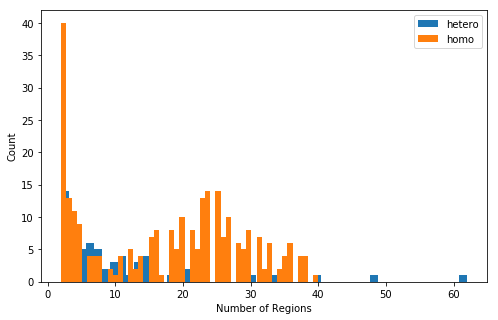

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(hetero_list, bins=50, label='hetero')
ax.hist(homo_list, bins=50, label='homo')
plt.xlabel('Number of Regions')
plt.ylabel('Count')
plt.legend()